In [235]:
from pathlib import Path
from projectyl.utils import fit_camera_pose as fit_cam
from projectyl import root_dir
from projectyl.video.props import INTRINSIC_MATRIX, THUMBS, SIZE
from projectyl.dynamics.inverse_kinematics import build_arm_model
from projectyl.utils.pose_overlay import get_4D_homogeneous_vector
from matplotlib import pyplot as plt
import numpy as np
global_params = {}
build_arm_model(global_params, headless=True)
arm_robot = global_params["arm"]
viz = global_params.get("viz", None)
video_path = Path(root_dir)/"__out/0011_arm_calibration"
arm_side = "right"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
data3d, data2d, intrinsic_matrix, config = fit_cam.get_camera_pose_fit_data_from_files(video_path)
h, w = int(config[THUMBS][SIZE][0]), int(config[THUMBS][SIZE][1])
p3d, p2d, q_states = fit_cam.build_3d_2d_data_arrays(data3d, data2d, (h,w),arm_side=arm_side)
p3d.shape, p2d.shape, q_states.shape

((496, 9), (496, 9), (496, 5))

### joints config $q$ -> 4D $X$ -> 2D $x$ Projection function

In [30]:
p4d_data_in = fit_cam.config_states_to_4d_points(q_states, arm_robot)

In [31]:
extr_array = np.array([fit_cam.get_extrinsics_default()]*len(q_states))

In [32]:
p2d_estim = fit_cam.project_4d_points_to_2d(p4d_data_in, intrinsic_matrix, extr_array)

# Optimize pose

- First compute a smooth solution over moving windows
- Then solve the whole problem.

In [207]:
# solution = least_squares(cost_function, init_var, args=(point_4d_data, point_2d_data, intrinsic_matrix)).x
solutions = []
flat_solution = []
window = 10
for t in range(window, len(p4d_data_in), 2*window+1):
    start=max(0, t-window)
    end = min(t+window+1, len(p4d_data_in))
    win_p4d = p4d_data_in[start:end, :]
    win_p2d = p2d[start:end, :]
    solution = fit_cam.optimize_camera_pose(win_p4d, win_p2d, intrinsic_matrix, cam_smoothness=0.03)
    flat_solution.append(solution)
    solution = solution.reshape(-1, 3)
    solutions.append(solution)
solutions_seq = np.concatenate(solutions, axis=0) # for visualization
init_solution = np.concatenate(flat_solution)

(496, 3)

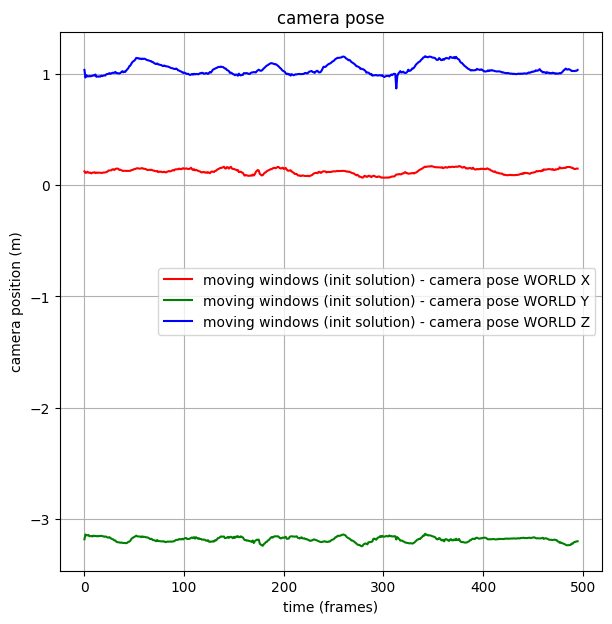

In [245]:
solutions_seq_world = np.array([get_4D_homogeneous_vector(sol, reverse=True) for sol in solutions_seq])
fit_cam.__plot_camera_pose(
    {
        # "moving windows (init solution) - camera pose": solutions_seq,
        "moving windows (init solution) - camera pose WORLD": solutions_seq_world,
    }
)

In [216]:
full_solution = fit_cam.optimize_camera_pose(p4d_data_in, p2d, intrinsic_matrix, init_var=init_solution, cam_smoothness=0.05)
full_solution = full_solution.reshape(-1, 3)

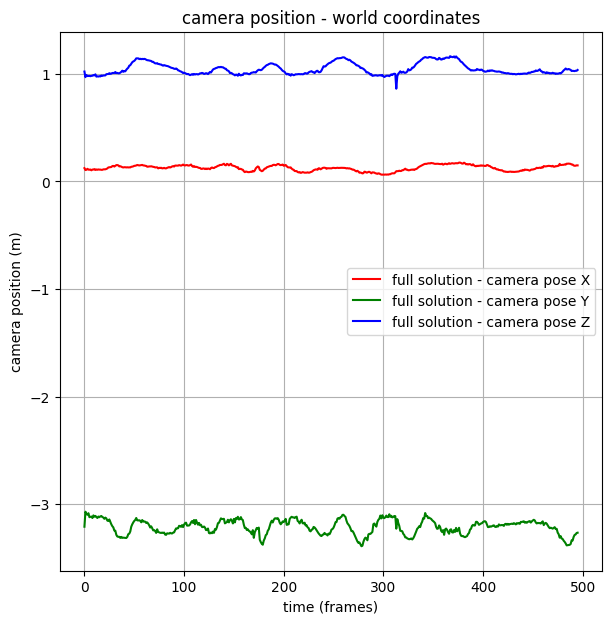

In [247]:
full_solution_world = np.array([get_4D_homogeneous_vector(sol, reverse=True) for sol in full_solution])
fit_cam.__plot_camera_pose(
    {
        "full solution - camera pose": full_solution_world,
        # "window init_solution - camera pose": solutions_seq,
    }
)

# Visualize 2D points

In [248]:
extr_array = np.array([
    fit_cam.get_extrinsics_default(full_solution_world[t_index, :]) for t_index in range(len(q_states))
])
p2d_fit = fit_cam.project_4d_points_to_2d(p4d_data_in, intrinsic_matrix, extr_array)



In [257]:
diff = (p2d_fit-p2d)

reprojection_error_shoulder = np.linalg.norm(diff[:, 0:2], axis=1).mean()
reprojection_error_elbow = np.linalg.norm(diff[:, 3:5], axis=1).mean()
reprojection_error_wrist = np.linalg.norm(diff[:, 6:8], axis=1).mean()

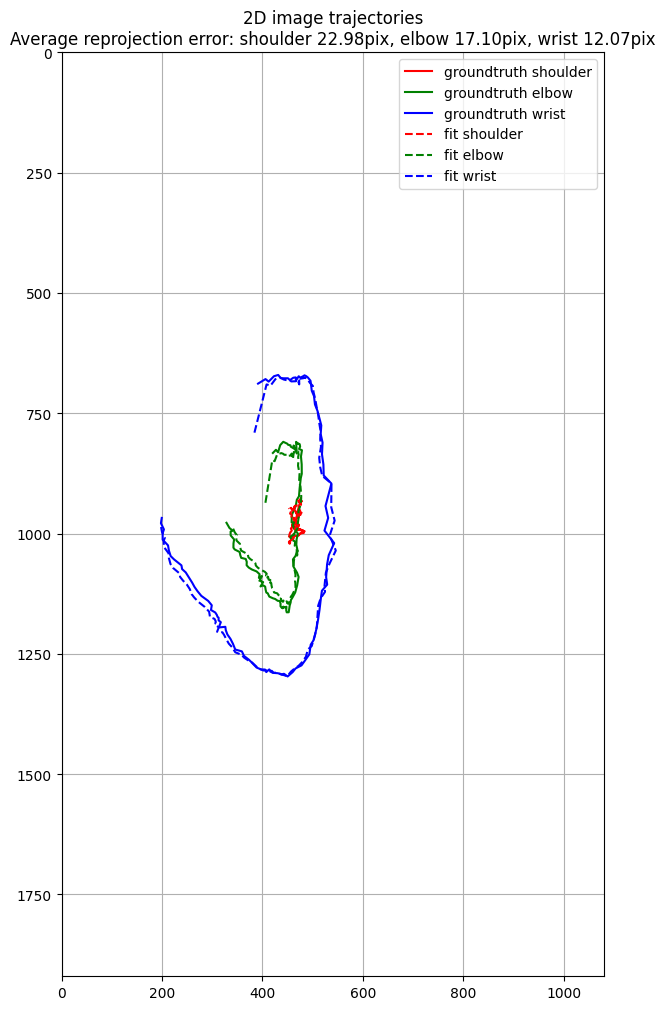

In [265]:
# % Visualize 2d trajectories
fit_cam.visualize_2d_trajectories(
    {
        "groundtruth": p2d,
        f"fit": p2d_fit,
        # "estimated": p2d_estim
    },
    (h, w),
    t_end=100,
    title=f"2D image trajectories\nAverage reprojection error: shoulder {reprojection_error_shoulder:.2f}pix, elbow {reprojection_error_elbow:.2f}pix, wrist {reprojection_error_wrist:.2f}pix"
)

### Manual proj

In [ ]:
p2d_estim, p3d_estim, p4d_estim = fit_cam.__get_all_projections_from_arm_config_estimations(
    q_states,
    arm_robot,
    intrinsic_matrix,
    [fit_cam.get_extrinsics_default()]*len(q_states)
)
p2d_estim.shape, p3d_estim.shape, p4d_estim.shape 

In [ ]:
p4d_data_in = fit_cam.get_4d_points_from_arm_config_estimations(q_states, arm_robot)

In [ ]:
fit_cam.visualize_2d_trajectories({
    "groundtruth": p2d,
    "estimation default": p2d_estim,
},
(h, w))

In [ ]:
p4d_input = p4d_estim.reshape(-1, 3, 4).transpose(0,2,1)
p2d_target = p2d.reshape(-1, 3, 3)

In [ ]:
p4d_input.shape

In [ ]:
p4d_data_in[5]

In [ ]:

p4d_input[5], p2d_target[5]

In [ ]:
import numpy as np
extr_array = np.array([fit_cam.get_extrinsics_default()]*len(q_states))

In [ ]:
extr_array.shape, p4d_input.shape

In [ ]:
# extr_array[:, 0, -1] = 0.
ext_p4d = np.matmul(extr_array, p4d_input)
p2d_proj = np.matmul(intrinsic_matrix, ext_p4d)
print(p2d_proj[5])
p2d_proj = p2d_proj/p2d_proj[:, 2:, :]
print(p2d_proj[5])
p2d_proj = p2d_proj.transpose(0, 2, 1).reshape(-1, p2d_proj.shape[-1]*p2d_proj.shape[-2])
print(p2d_proj[5])

In [ ]:
fit_cam.visualize_2d_trajectories({
    "groundtruth": p2d,
    "estimation default": p2d_proj,
},
(h, w))